In [1]:
import yaml
import math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')

In [2]:
excel = Path("../Data/Asplund_2008.xlsx")

In [3]:
protosolar = {'X': 0.7154, 'Y': 0.2703, 'Z': 0.0142}
present_day = {'X': 0.7381, 'Y': 0.2485, 'Z': 0.0134}

In [11]:
df_ppn = pd.read_excel(excel, sheet_name = "nuppn_presentday")
# GroupBy Element
df_ppn['Abundance_nd'] = df_ppn['Abundance'] / df_ppn['mass']
nuppn_df = df_ppn.groupby(['Z', "Element"])["Abundance"].sum().reset_index()

nuppn_nd_df = df_ppn.groupby(['Z', "Element"])["Abundance_nd"].sum().reset_index()

In [12]:
total = nuppn_df.Abundance.sum()
hydrogen = float(nuppn_df.Abundance[nuppn_df.Element == 'H'])
heliumn = float(nuppn_df.Abundance[nuppn_df.Element == 'He'])
metal = nuppn_df.Abundance[(nuppn_df.Element != 'H') & (nuppn_df.Element != 'He')].sum()
    
if (abs(total - 1) < 0.001) and (abs(hydrogen - protosolar['X']) < 0.001) and (abs(heliumn - protosolar['Y']) < 0.001) and (abs(metal - protosolar['Z']) < 0.001):
    print('NuPPn matches protosolar X, Y and Z')
print(total - 1, hydrogen - protosolar['X'], heliumn - protosolar['Y'], metal - protosolar['Z'])

print(f"Total: {total} Hydrogen: {hydrogen} Heliumn: {heliumn} Metal: {metal}")

1.070699084948501e-12 0.02059524423148895 -0.01974183842228494 -0.0007534058081330678
Total: 1.0000000000010707 Hydrogen: 0.735995244231489 Heliumn: 0.25055816157771504 Metal: 0.013446594191866933


In [13]:
h_factor = present_day['X']/hydrogen
he_factor = present_day['Y']/heliumn
metal_factor = present_day['Z']/metal

nuppn_df['factor'] = [h_factor, he_factor] + [metal_factor] * (len(nuppn_df) -2)
nuppn_df['Abundance_adj'] = nuppn_df['Abundance'] * nuppn_df['factor'] 

total_adj = nuppn_df.Abundance.sum()
hydrogen_adj = float(nuppn_df.Abundance_adj[nuppn_df.Element == 'H'])
heliumn_adj = float(nuppn_df.Abundance_adj[nuppn_df.Element == 'He'])
metal_adj = nuppn_df.Abundance_adj[(nuppn_df.Element != 'H') & (nuppn_df.Element != 'He')].sum()
    
if (abs(total_adj - 1) < 0.001) and (abs(hydrogen_adj - present_day['X']) < 0.001) and (abs(heliumn_adj - present_day['Y']) < 0.001) and (abs(metal_adj - present_day['Z']) < 0.001):
    print('NuPPN adjusted matches present_day X, Y, Z')
print(total_adj - 1, hydrogen_adj - present_day['X'], heliumn_adj - present_day['Y'], metal_adj - present_day['Z'])

print(f"Total: {total_adj} Hydrogen: {hydrogen_adj} Heliumn: {heliumn_adj} Metal: {metal_adj}")

NuPPN adjusted matches present_day X, Y, Z
1.070699084948501e-12 0.0 0.0 1.734723475976807e-18
Total: 1.0000000000010707 Hydrogen: 0.7381 Heliumn: 0.2485 Metal: 0.013400000000000002


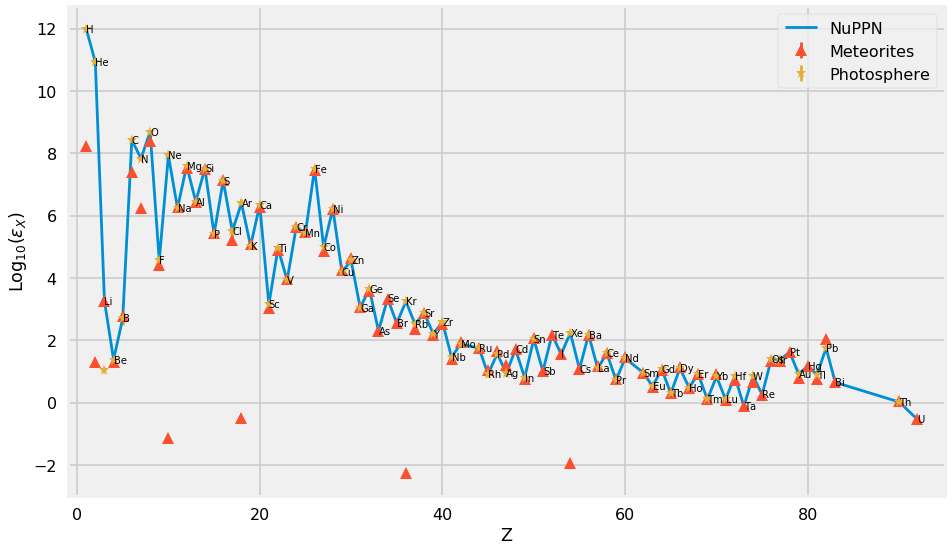

In [28]:
fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(1,1,1)

# Plot Nuppn
dex = []
for z, abundance in zip(nuppn_nd_df.Z, nuppn_nd_df.Abundance_nd):
    dex.append(np.log10(abundance/nuppn_nd_df.Abundance_nd.iloc[0])+12.0)
ax.plot(nuppn_nd_df.Z, dex, label="NuPPN")

# Plot Asplund 2008
df = pd.read_excel(excel)
ax.errorbar(x=df.Z, y=df.Meteorites, yerr=df["Meteorites uncertainty"], fmt='^', label="Meteorites")
ax.errorbar(x=df.Z, y=df.Photosphere, yerr=df["Photosphere uncertanty"], fmt='*', label="Photosphere")

# Element Labels
for element, z, photo in zip(df.Element, df.Z, dex):
    ax.text(z, photo-0.1, element)
        
ax.set_xlim(-1,95)        
ax.legend(loc=1)
ax.set_xlabel('Z')
ax.set_ylabel('Log$_{10}$($\epsilon_X$)');

0.8016910279819645
0.000768529382247145


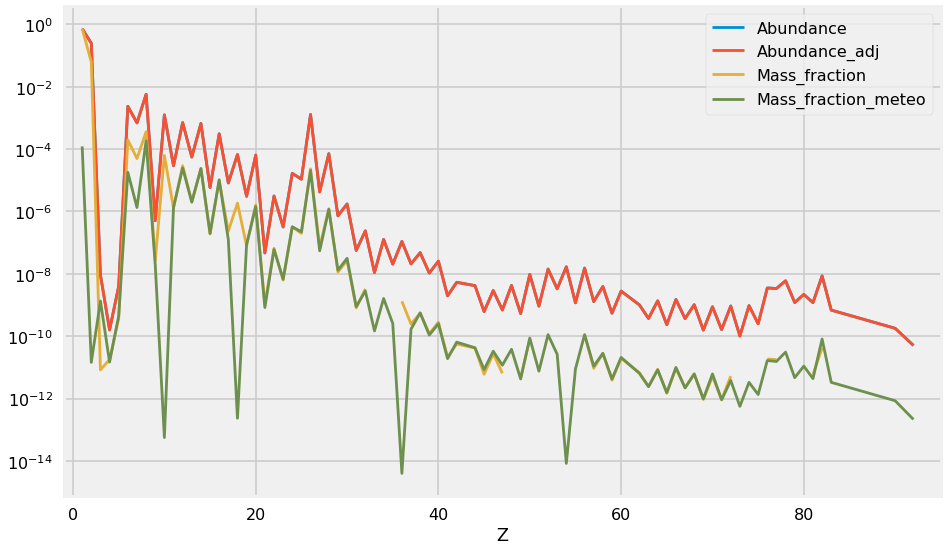

In [15]:
df['Mass_fraction'] = 10**(df.Photosphere - 12) * present_day['X']
df['Mass_fraction_meteo'] = 10**(df.Meteorites - 12) * present_day['X']

fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(1,1,1)

nuppn_df.plot(x='Z', y='Abundance',ax=ax, logy=True)
nuppn_df.plot(x='Z', y='Abundance_adj',ax=ax, logy=True);

df.plot(x='Z', y='Mass_fraction', logy=True, ax=ax)
df.plot(x='Z', y='Mass_fraction_meteo', logy=True, ax=ax)

print(df.Mass_fraction.sum())
print(df.Mass_fraction[(df.Element != 'H') & (df.Element != 'He')].sum())

ax.set_xlim(-1,95)        
ax.legend(loc=1)
ax.set_xlabel('Z');

In [100]:
path = Path("../Data/Asplund.yml")
assert not path.is_file()

AssertionError: 

In [ ]:
abu = {e:p for e, p in zip(df.Element, df.Photosphere) if not math.isnan(p)} 
error = {e:p for e, p in zip(df.Element, df["Photosphere uncertanty"]) if not math.isnan(p)} 
error['H'] = 0

dic = {"Star": "Sun", "Abundance": {"Loge": abu, "Loge_error": error}}

In [ ]:
with path.open('w') as file:
    yaml.dump(dic, file)

In [58]:
with Path("../Data/Asplund.yml").open() as file:
    asplund = yaml.load(file, Loader=yaml.FullLoader)

print(asplund)

assert len(asplund['Abundance']['Loge']) == len(asplund['Abundance']['Loge_error'])

{'Abundance': {'Loge': {'Ag': 0.94, 'Al': 6.45, 'Ar': 6.4, 'Au': 0.92, 'B': 2.7, 'Ba': 2.18, 'Be': 1.38, 'C': 8.43, 'Ca': 6.34, 'Ce': 1.58, 'Cl': 5.5, 'Co': 4.99, 'Cr': 5.64, 'Cu': 4.19, 'Dy': 1.1, 'Er': 0.92, 'Eu': 0.52, 'F': 4.56, 'Fe': 7.5, 'Ga': 3.04, 'Gd': 1.07, 'Ge': 3.65, 'H': 12.0, 'He': 10.93, 'Hf': 0.85, 'Ho': 0.48, 'In': 0.8, 'Ir': 1.38, 'K': 5.03, 'Kr': 3.25, 'La': 1.1, 'Li': 1.05, 'Lu': 0.1, 'Mg': 7.6, 'Mn': 5.43, 'Mo': 1.88, 'N': 7.83, 'Na': 6.24, 'Nb': 1.46, 'Nd': 1.42, 'Ne': 7.93, 'Ni': 6.22, 'O': 8.69, 'Os': 1.4, 'P': 5.41, 'Pb': 1.75, 'Pd': 1.57, 'Pr': 0.72, 'Rb': 2.52, 'Rh': 0.91, 'Ru': 1.75, 'S': 7.12, 'Sc': 3.15, 'Si': 7.51, 'Sm': 0.96, 'Sn': 2.04, 'Sr': 2.87, 'Tb': 0.3, 'Th': 0.02, 'Ti': 4.95, 'Tl': 0.9, 'Tm': 0.1, 'V': 3.93, 'W': 0.85, 'Xe': 2.24, 'Y': 2.21, 'Yb': 0.84, 'Zn': 4.56, 'Zr': 2.58}, 'Loge_error': {'Ag': 0.1, 'Al': 0.03, 'Ar': 0.13, 'Au': 0.1, 'B': 0.2, 'Ba': 0.09, 'Be': 0.09, 'C': 0.05, 'Ca': 0.04, 'Ce': 0.04, 'Cl': 0.3, 'Co': 0.07, 'Cr': 0.04, 'Cu': 